### Load libraries and inspect data

In [1]:
# load modules
from pyspark.sql import SparkSession
from functools import reduce 
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

from pyspark.mllib.stat import Statistics as stat
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

from pyspark.sql import DataFrame
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, IntegerType
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, isnan, count, udf, struct, date_format, coalesce, lit, round
from math import sin, cos, sqrt, atan2, radians    
from pyspark.sql.functions import col, radians, asin, sin, sqrt, cos

In [2]:
spark = SparkSession.builder \
        .appName("model") \
        .config("spark.executor.memory", '18g') \
        .config('spark.executor.cores', '5') \
        .config('spark.executor.instances', '29') \
        .getOrCreate()

In [3]:
#Load data in
data = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/master_dataset.parquet')
print(type(data))

<class 'pyspark.sql.dataframe.DataFrame'>


In [4]:
#inspect
data.show(3)

+--------+----------+--------------+--------------------+--------------------+---------------------+----------+----+------------+--------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+---+------+-----+--------+------------+----+---------+---------+---------+--------------------+--------------------+--------+------------------+------------------+----------------------+----------------------+----------------------+-------------------+------------------+-------------------+------------------+--------------------+
| Borough|month_year|startStationId|    startStationName|startStationLatitude|startStationLongitude|      date|hour|tripduration|           starttime|endStationId|      endStationName|endStationLatitude|endStationLongitude| bikeid|  usertype|birthyear|gender|  temp|feels_like|temp_min|te

#### Create new columns (holiday, distance, and binary (numeric) bins for string features

In [5]:
## Create Distnace columns
# radius of earth in miles
R = 3963.0

#Convert start/end latitude and longitude from degrees to Radians
#Create holiday column binary, 1 yes, 0 no
data = data.withColumn("startRadLong", radians(data.startStationLongitude))
data = data.withColumn("endRadLong", radians(data.endStationLongitude))
data = data.withColumn("startRadLat", radians(data.startStationLatitude))
data = data.withColumn("endRadLat", radians(data.endStationLatitude))
data = data.withColumn("diffRadLong", (data.startRadLong-data.endRadLong))
data = data.withColumn("diffRadLat", (data.startRadLat-data.endRadLat))
data = data.withColumn("crowDist", asin(sqrt(sin(data.diffRadLat/2)**2 + cos(data.startRadLat) * cos(data.endRadLat) * sin(data.diffRadLong/2)**2)) * 2 * R)
data = data.drop("startRadLong","endRadLong","startRadLat","endRadLat","diffRadLong","diffRadLat")

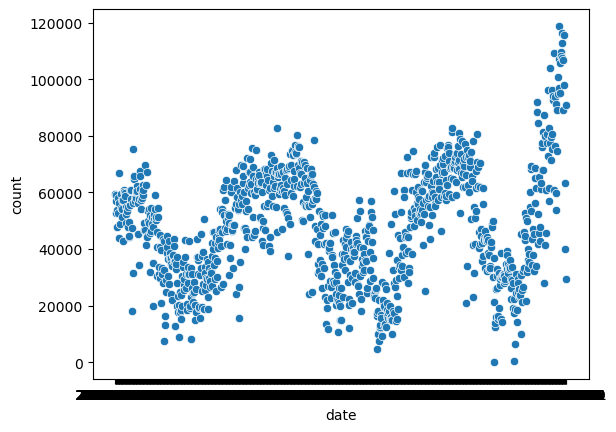

In [6]:
#plot to see counts of trips from 2018-2021
sns.scatterplot(data = data.groupby("date").count().orderBy("date").toPandas(), x = 'date', y = 'count')
plt.show() #we see the waxing/waning nature of daily trips by time of year

Early hypothesis is that trips decrease around holidays and can use the count of trips as a strong predictor.

In [6]:
#count of trips by day
cnt_trip = data.groupby("date").count()
cnt_trip.show(3)

+----------+-----+
|      date|count|
+----------+-----+
|2020-02-26|44503|
|2019-08-08|68714|
|2019-08-22|60527|
+----------+-----+
only showing top 3 rows



In [7]:
#we'll slice to grouped data
#Get a count of station
grouped_data = data.groupby("date")
agg_data = grouped_data.agg(F.avg("avg_median_sales_price").alias("current_month_avg_median_sales_price"),
                 F.avg("crowDist").alias("avg_crowDist"),
                 F.stddev("crowDist").alias("std_crowDist"), 
                 F.avg("feels_like").alias("avg_feels_like"),
                 F.stddev("feels_like").alias("std_feels_like"),
                 F.avg("humidity").alias("avg_humidity"),
                 F.stddev("humidity").alias("std_humidity"), 
                 F.avg("wind_speed").alias("avg_wind_speed"),
                 F.stddev("wind_speed").alias("std_wind_speed"),
                 F.avg("tripduration").alias("avg_tripduration"),
                 F.stddev("tripduration").alias("std_tripduration"),
                 F.count(when(data.usertype == "Customer", lit(1))).alias("customer_count"),
                 F.count(when(data.usertype == "Subscriber", lit(1))).alias("subscriber_count"),
                 F.count(when(data.usertype == "member", lit(1))).alias("member_count"),
                 F.count(when(data.peak_commute == "peak", lit(1))).alias("peak_count"),
                 F.count(when(data.peak_commute == "non_peak", lit(1))).alias("non_peak_count"),
                 F.count(when(data.precip == "precip", lit(1))).alias("precip_count"),
                 F.count(when(data.precip == "no_precip", lit(1))).alias("non_precip_count"),
                 F.count(when(data.time_bin == "Morning", lit(1))).alias("morning_count"),
                 F.count(when(data.time_bin == "Afternoon", lit(1))).alias("afternoon_count"),
                 F.count(when(data.time_bin == "Evening", lit(1))).alias("evening_count"),
                 F.count(when(data.time_bin == "Night", lit(1))).alias("night_count"))

In [59]:
#inspect
agg_data.show(2)

+----------+------------------------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+--------------+----------------+------------+----------+--------------+------------+----------------+-------------+---------------+-------------+-----------+
|      date|current_month_avg_median_sales_price|      avg_crowDist|      std_crowDist|   avg_feels_like|    std_feels_like|     avg_humidity|     std_humidity|    avg_wind_speed|   std_wind_speed|  avg_tripduration|  std_tripduration|customer_count|subscriber_count|member_count|peak_count|non_peak_count|precip_count|non_precip_count|morning_count|afternoon_count|evening_count|night_count|
+----------+------------------------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------

In [8]:
#Get dataframe with counts
df = agg_data.join(cnt_trip, agg_data.date==cnt_trip.date, how="inner").drop(cnt_trip.date)
df = df.orderBy("date").withColumnRenamed("count", "trip_count")

In [61]:
#inspect
df.show(3)

+------------------------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------+----------------+------------+----------+--------------+------------+----------------+-------------+---------------+-------------+-----------+----------+----------+
|current_month_avg_median_sales_price|      avg_crowDist|      std_crowDist|   avg_feels_like|   std_feels_like|     avg_humidity|     std_humidity|    avg_wind_speed|    std_wind_speed| avg_tripduration|  std_tripduration|customer_count|subscriber_count|member_count|peak_count|non_peak_count|precip_count|non_precip_count|morning_count|afternoon_count|evening_count|night_count|      date|trip_count|
+------------------------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+--------

In [9]:
#create a holiday list
dr = pd.date_range(start='2016-01-01', end='2021-12-31')
cal = calendar()
holi = cal.holidays(start=dr.min(), end=dr.max())
holiday = pd.DataFrame(data=holi)
holiday = holiday[0].astype(str).tolist()

#add to dataframe
df = df.withColumn("holiday", when(df.date.isin(holiday), 1).otherwise(0))

In [63]:
#Inspect
df.show(3)

+------------------------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------+----------------+------------+----------+--------------+------------+----------------+-------------+---------------+-------------+-----------+----------+----------+-------+
|current_month_avg_median_sales_price|      avg_crowDist|      std_crowDist|   avg_feels_like|   std_feels_like|     avg_humidity|     std_humidity|    avg_wind_speed|    std_wind_speed| avg_tripduration|  std_tripduration|customer_count|subscriber_count|member_count|peak_count|non_peak_count|precip_count|non_precip_count|morning_count|afternoon_count|evening_count|night_count|      date|trip_count|holiday|
+------------------------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------

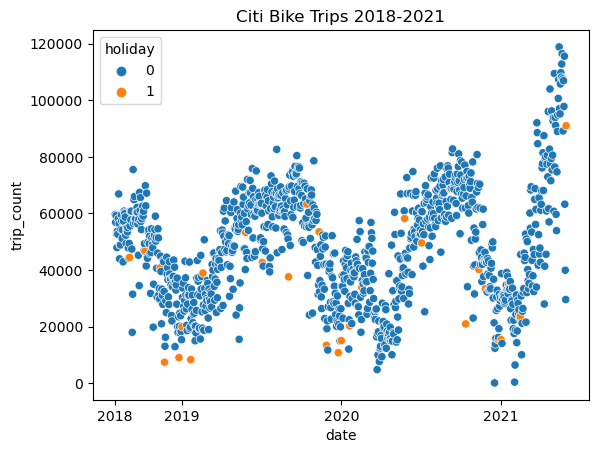

In [32]:
#Plot to see count of trip indexed by holiday
#Graph labels
x_val = ['2018-08-01','2019-01-01','2020-01-01', '2021-01-01']
years = ['2018', '2019', '2020', '2021']
sns.scatterplot(data = df.toPandas(), x = 'date', y = 'trip_count', hue="holiday")
plt.title("Citi Bike Trips 2018-2021")
plt.xticks(x_val, years)
plt.show() 

In [15]:
#Is a holiday 1, not holiday 0
df.select("holiday").distinct().show()

+-------+
|holiday|
+-------+
|      1|
|      0|
+-------+



In [16]:
#Count of holidays
df.groupby("holiday").count().show()

+-------+-----+
|holiday|count|
+-------+-----+
|      1|   29|
|      0| 1005|
+-------+-----+



---

#### Check correlation of selected variables

In [17]:
#Select only data features we want to see correlations
dfc = df.drop("date")

In [18]:
#Null values
dfc.select([count(when(isnan(c), c)).alias(c) for c in dfc.columns]).show() 

+------------------------------------+------------+------------+--------------+--------------+------------+------------+--------------+--------------+----------------+----------------+----------+--------------+------------+----------------+-------------+---------------+-------------+-----------+----------+-------+
|current_month_avg_median_sales_price|avg_crowDist|std_crowDist|avg_feels_like|std_feels_like|avg_humidity|std_humidity|avg_wind_speed|std_wind_speed|avg_tripduration|std_tripduration|peak_count|non_peak_count|precip_count|non_precip_count|morning_count|afternoon_count|evening_count|night_count|trip_count|holiday|
+------------------------------------+------------+------------+--------------+--------------+------------+------------+--------------+--------------+----------------+----------------+----------+--------------+------------+----------------+-------------+---------------+-------------+-----------+----------+-------+
|                                   0|           0| 

In [19]:
#Drop nan
dfc = dfc.dropna()

In [20]:
#Print Schema
dfc.printSchema()

root
 |-- current_month_avg_median_sales_price: double (nullable = true)
 |-- avg_crowDist: double (nullable = true)
 |-- std_crowDist: double (nullable = true)
 |-- avg_feels_like: double (nullable = true)
 |-- std_feels_like: double (nullable = true)
 |-- avg_humidity: double (nullable = true)
 |-- std_humidity: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- std_wind_speed: double (nullable = true)
 |-- avg_tripduration: double (nullable = true)
 |-- std_tripduration: double (nullable = true)
 |-- peak_count: long (nullable = false)
 |-- non_peak_count: long (nullable = false)
 |-- precip_count: long (nullable = false)
 |-- non_precip_count: long (nullable = false)
 |-- morning_count: long (nullable = false)
 |-- afternoon_count: long (nullable = false)
 |-- evening_count: long (nullable = false)
 |-- night_count: long (nullable = false)
 |-- trip_count: long (nullable = false)
 |-- holiday: integer (nullable = false)



In [21]:
from pyspark.mllib.stat import Statistics as stat
#Check correlation
#numeric_feat = [i[0] for i in dfc.dtypes if i[1] != "string"]
#numeric_feat_df = dfc.select(numeric_feat)
col_names = dfc.columns
feat = dfc.rdd.map(lambda row: row[0:])

In [22]:
#corr
corr_ = stat.corr(feat, method="pearson")

In [23]:
#Corr to pandas DF
corr_df = pd.DataFrame(corr_)
corr_df.index, corr_df.columns = col_names, col_names
corr_df

,current_month_avg_median_sales_price,avg_crowDist,std_crowDist,avg_feels_like,std_feels_like,avg_humidity,std_humidity,avg_wind_speed,std_wind_speed,avg_tripduration,...,peak_count,non_peak_count,precip_count,non_precip_count,morning_count,afternoon_count,evening_count,night_count,trip_count,holiday
current_month_avg_median_sales_price,1.000000,-0.311796,-0.351623,-0.151356,-0.002228,-0.019029,0.027825,0.017733,0.030442,-0.301616,...,0.091068,-0.072722,0.171181,-0.098814,0.142766,-0.076008,-0.007808,-0.038649,0.009214,-0.028156
avg_crowDist,-0.311796,1.000000,0.948372,0.532827,0.290134,-0.142307,0.196227,-0.226556,-0.131097,0.744060,...,0.105794,0.536153,-0.106795,0.565652,0.202559,0.657602,0.503946,0.459940,0.554571,-0.063927
std_crowDist,-0.351623,0.948372,1.000000,0.408231,0.224522,-0.138428,0.154195,-0.155584,-0.059447,0.750179,...,0.059681,0.412634,-0.106001,0.434571,0.054123,0.546339,0.385358,0.354742,0.409396,-0.035514
avg_feels_like,-0.151356,0.532827,0.408231,1.000000,0.282960,0.302197,0.171901,-0.392008,-0.238388,0.415674,...,0.318882,0.439477,0.157370,0.477689,0.465794,0.480310,0.641955,0.656340,0.640527,-0.031930
std_feels_like,-0.002228,0.290134,0.224522,0.282960,1.000000,-0.263583,0.155932,-0.183002,-0.076701,0.206855,...,0.151451,0.259120,-0.164895,0.416530,0.223253,0.327313,0.329021,0.264465,0.348374,-0.044828
avg_humidity,-0.019029,-0.142307,-0.138428,0.302197,-0.263583,1.000000,-0.045572,-0.169744,-0.020508,-0.069272,...,0.036167,-0.062537,0.632330,-0.418865,0.034869,-0.095041,-0.008814,0.036938,-0.025834,0.028754
std_humidity,0.027825,0.196227,0.154195,0.171901,0.155932,-0.045572,1.000000,0.011066,0.126007,0.167421,...,0.108880,0.123807,0.082152,0.124632,0.162700,0.156500,0.182939,0.143350,0.195701,-0.020475
avg_wind_speed,0.017733,-0.226556,-0.155584,-0.392008,-0.183002,-0.169744,0.011066,1.000000,0.617600,-0.123900,...,-0.128922,-0.219258,-0.036050,-0.243153,-0.236353,-0.244133,-0.258785,-0.294094,-0.295398,0.040396
std_wind_speed,0.030442,-0.131097,-0.059447,-0.238388,-0.076701,-0.020508,0.126007,0.617600,1.000000,-0.092177,...,-0.060618,-0.155639,0.112054,-0.236461,-0.142536,-0.149586,-0.168224,-0.190027,-0.184940,-0.033619
avg_tripduration,-0.301616,0.744060,0.750179,0.415674,0.206855,-0.069272,0.167421,-0.123900,-0.092177,1.000000,...,-0.246941,0.430402,-0.137622,0.247454,-0.197829,0.407863,0.156406,0.268507,0.179377,0.033350


---

#### Rename column and explore

In [10]:
#rename holiday to label
df = df.withColumnRenamed("holiday", "label")
df.show(2)

+------------------------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------+----------------+------------+----------+--------------+------------+----------------+-------------+---------------+-------------+-----------+----------+----------+-----+
|current_month_avg_median_sales_price|      avg_crowDist|      std_crowDist|   avg_feels_like|   std_feels_like|     avg_humidity|     std_humidity|    avg_wind_speed|    std_wind_speed| avg_tripduration|  std_tripduration|customer_count|subscriber_count|member_count|peak_count|non_peak_count|precip_count|non_precip_count|morning_count|afternoon_count|evening_count|night_count|      date|trip_count|label|
+------------------------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+---------------

In [11]:
#drop date and print schema
df = df.drop("date")
df.printSchema()

root
 |-- current_month_avg_median_sales_price: double (nullable = true)
 |-- avg_crowDist: double (nullable = true)
 |-- std_crowDist: double (nullable = true)
 |-- avg_feels_like: double (nullable = true)
 |-- std_feels_like: double (nullable = true)
 |-- avg_humidity: double (nullable = true)
 |-- std_humidity: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- std_wind_speed: double (nullable = true)
 |-- avg_tripduration: double (nullable = true)
 |-- std_tripduration: double (nullable = true)
 |-- customer_count: long (nullable = false)
 |-- subscriber_count: long (nullable = false)
 |-- member_count: long (nullable = false)
 |-- peak_count: long (nullable = false)
 |-- non_peak_count: long (nullable = false)
 |-- precip_count: long (nullable = false)
 |-- non_precip_count: long (nullable = false)
 |-- morning_count: long (nullable = false)
 |-- afternoon_count: long (nullable = false)
 |-- evening_count: long (nullable = false)
 |-- night_count: long (nu

In [26]:
#Count rows
df.count()

1034

In [12]:
#Drop nulls, there isn't any
df = df.dropna()
df.count()

1034

### Create pipeline

In [13]:
#Get non-string feats
num_feat = [i[0] for i in df.dtypes if i[1] != "string"]
#cols = set(data.columns)-set(num_feat)
#cols
num_feat

['current_month_avg_median_sales_price',
 'avg_crowDist',
 'std_crowDist',
 'avg_feels_like',
 'std_feels_like',
 'avg_humidity',
 'std_humidity',
 'avg_wind_speed',
 'std_wind_speed',
 'avg_tripduration',
 'std_tripduration',
 'customer_count',
 'subscriber_count',
 'member_count',
 'peak_count',
 'non_peak_count',
 'precip_count',
 'non_precip_count',
 'morning_count',
 'afternoon_count',
 'evening_count',
 'night_count',
 'trip_count',
 'label']

In [14]:
#PIPELINE indexer-standard scalar
#indexer = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in cols]

#encoder = [OneHotEncoder(inputCol=index.getOutputCol(), outputCol="{0}_encoded".format(index.getOutputCol())) for index in indexer]

#assembler = VectorAssembler(inputCols=[enc.getOutputCol() for enc in encoder] + list((set(num_feat)-set(["label"]))), outputCol="vectorized_features")
assembler = VectorAssembler(inputCols=list((set(num_feat)-set(["label"]))), outputCol="vectorized_features")

standardScaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="features")

#pipeline
pipeline = Pipeline(stages=[assembler] + [standardScaler])

In [15]:
#Get model
model = pipeline.fit(df)
df_tr = model.transform(df)

In [16]:
#inspect
df_tr.show(2)

+------------------------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------+----------------+------------+----------+--------------+------------+----------------+-------------+---------------+-------------+-----------+----------+-----+--------------------+--------------------+
|current_month_avg_median_sales_price|      avg_crowDist|      std_crowDist|   avg_feels_like|   std_feels_like|     avg_humidity|     std_humidity|    avg_wind_speed|    std_wind_speed| avg_tripduration|  std_tripduration|customer_count|subscriber_count|member_count|peak_count|non_peak_count|precip_count|non_precip_count|morning_count|afternoon_count|evening_count|night_count|trip_count|label| vectorized_features|            features|
+------------------------------------+------------------+------------------+-----------------+-----------------+--------

#### Train/test split

In [16]:
#train/test split
train, test = df_tr.randomSplit([0.7,0.3], seed = 2021)

In [33]:
#Inspect
print(train.groupby("label").count().show())
print(test.groupby("label").count().show())

+-----+-----+
|label|count|
+-----+-----+
|    1|   19|
|    0|  718|
+-----+-----+

None
+-----+-----+
|label|count|
+-----+-----+
|    1|   10|
|    0|  287|
+-----+-----+

None


#### Logistic Regression Base Model - NOT Tuned and NOT downsampled

In [17]:
#Fit log reg
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol='label', featuresCol='features', maxIter=3)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)

In [18]:
#Coeff and intercept
print("Weights: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Weights: [-0.14573506548708462,-0.07235138795504294,0.11244043769904845,-0.12591733949188685,0.000686817104283308,-0.0033007733722967975,0.09252993772093382,-0.018685350098220383,-0.1796671365204413,0.061206977138004624,-0.018977912459814682,0.08102433123634324,-0.02290260817649053,-0.018466994007919367,-0.0601862719946038,0.028143234782737975,0.14302383796862903,-0.0960779849158169,-0.12138679197272205,-0.0508765705113184]
Intercept: -3.6276432221369315


In [36]:
#View predictions
predictions.select('label', 'features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0,"[15.473365599619086, 5.263719368194076, 2.3968...","[3.5570267642953004, -3.5570267642953004]",0.0,"[0.972267521639917, 0.027732478360083062]"
1,0,"[15.47484977950182, 4.209057675058349, 1.87445...","[3.693354418928254, -3.693354418928254]",0.0,"[0.9757160131677141, 0.024283986832285935]"
2,0,"[15.500340297210792, 3.5839485324725624, 1.660...","[3.6578285609166956, -3.6578285609166956]",0.0,"[0.9748598748407378, 0.02514012515926227]"
3,0,"[15.445852515601304, 3.4517177715747955, 1.662...","[3.7095526119284163, -3.7095526119284163]",0.0,"[0.976096874458632, 0.023903125541368045]"
4,0,"[15.455542944645904, 4.389668102946936, 2.2741...","[3.9847156258798493, -3.9847156258798493]",0.0,"[0.981741828304619, 0.018258171695381086]"


In [19]:
#Evaluate AUROC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
roc = evaluator.evaluate(predictions)
print("Test AUROC:" + str(roc)) #0.7885 AUROC

Test AUROC:0.7885017421602785


In [20]:
#Evaluate accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : " + str(accuracy)) #too high? 0.966

Accuracy : 0.9663299663299664


Accuracy was good! It seems the percentage of holidays compared to sample size is so small. We downsampled the data to account for this possiblity.

### Let's try downsampling (actual holidays are much smaller than sample size)

In [17]:
#Downsampling to have closer count of 1.0 and 0.0 labels for holidays
def downsample(df, target, positive_label, negative_label):
    """
    df              spark dataframe
    target          str, target variable
    positive_label  int, value of positive label
    negative_label  int, value of negative label
    
    """

    
    if ((df.filter(df.label == positive_label).count()) > (df.filter(df.label == negative_label).count())):
        perc = df.filter(df.label == negative_label).count()/df.filter(df.label == positive_label).count()
        df_b = df.sampleBy(target, fractions={positive_label: perc, negative_label:1.0}, seed=123)
    else:
        perc = df.filter(df.label == positive_label).count()/df.filter(df.label == negative_label).count()
        df_b = df.sampleBy(target, fractions={positive_label: 1.0, negative_label:perc}, seed=123)
    
    
    return df_b


In [18]:
#Downsampled label
down = downsample(df_tr, 'label', 1, 0)
#split to test and train
train, test = down.randomSplit([0.7,0.3], seed=2021)

In [72]:
#New train count
print(train.groupby('label').count().show())
#New test count
print(test.groupby('label').count().show())

+-----+-----+
|label|count|
+-----+-----+
|    1|   18|
|    0|   17|
+-----+-----+

None
+-----+-----+
|label|count|
+-----+-----+
|    1|   11|
|    0|   11|
+-----+-----+

None


#### Logistic Regression Base Model - Tuned and downsampled

In [19]:
#Tune with PGB and CV
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

#log reg model
lr = LogisticRegression()

#Paramgrid
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0]) #regularization param
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) #Ridge=0, Lasso=1.0
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

#10 fold cross-validation
cv = CrossValidator(estimator=lr, estimatorParamMaps = paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=10)

In [20]:
#Fit the model
cvModel = cv.fit(train)

In [21]:
#Predictions
tune_preds = cvModel.transform(test)

In [23]:
#AUROC
evaluator=BinaryClassificationEvaluator()
best_roc = evaluator.evaluate(tune_preds)
print("Best Model Test AUROC : " + str(best_roc)) #0.7272

Best Model Test AUROC : 0.7272727272727274


In [24]:
#Evaluate accuracy
accuracy = tune_preds.filter(tune_preds.label == tune_preds.prediction).count() / float(tune_preds.count())
print("Accuracy : " + str(accuracy)) #not bad for lack of data - 727

Accuracy : 0.7272727272727273


In [25]:
#Best model paramaters
bm = cvModel.bestModel

print("Best model regularlization parameter: ", bm._java_obj.getRegParam()) #0.01
print("Best model elastic net parameter: ", bm._java_obj.getElasticNetParam()) #ridge 0.0
print("Best model iteration: ", bm._java_obj.getMaxIter()) #5

Best model regularlization parameter:  0.01
Best model elastic net parameter:  0.0
Best model iteration:  5


In [26]:
#Model Feature weights
best_coef = bm.coefficients

In [27]:
#Get list of importances and sort 
lis = []
for i in best_coef:
    lis.append(i)
output = list(zip(lis, num_feat[0:19]))
output = sorted(output, key=lambda x: x[0], reverse=True)
#The weights were numpy-float64 so I needed to change its type to be able to create spark df
output = [(float(x[0]), x[1]) for x in output]

In [28]:
#get DF
schema = StructType([
    StructField("weight", DoubleType(), True),
    StructField("name", StringType(), True)
])
df_ticks = spark.createDataFrame(output, schema).toPandas()

In [29]:
#inspect
df_ticks

,weight,name
0,0.296743,avg_feels_like
1,0.174289,avg_crowDist
2,0.098974,non_precip_count
3,0.080149,member_count
4,0.078434,peak_count
5,0.063885,customer_count
6,0.060616,std_humidity
7,0.052103,std_tripduration
8,-0.017641,precip_count
9,-0.030577,avg_tripduration


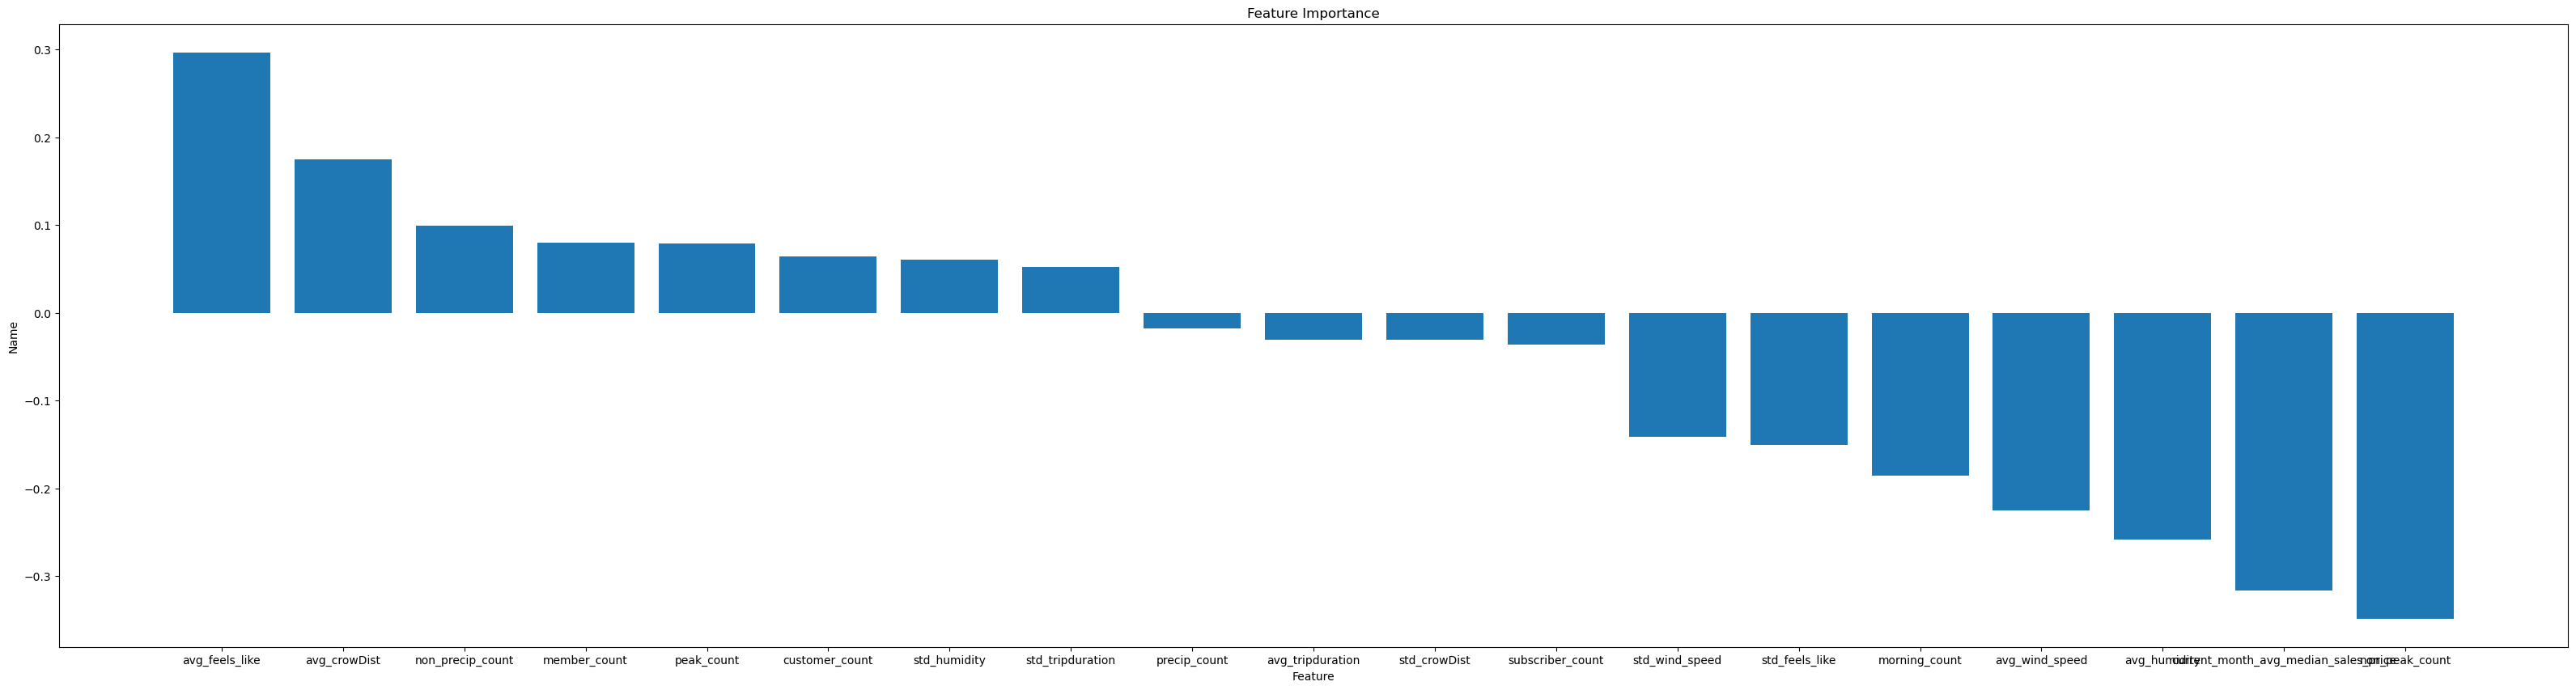

In [30]:
#plot of Feature Importance - need to work on graph look
plt.rcParams["figure.figsize"] = (40, 10)
plt.bar(df_ticks["name"], df_ticks["weight"], orientation = 'vertical')
plt.ylabel('Name')
plt.xlabel('Feature')
plt.title('Feature Importance')
plt.show()

Number of trips during precipitation and afternoon trips held the most weight.

---

---

# Random Forest Classification w/ All Variables

In [31]:
#Load Library
from pyspark.ml.regression import RandomForestRegressor

In [32]:
#get column names
data.columns

['Borough',
 'month_year',
 'startStationId',
 'startStationName',
 'startStationLatitude',
 'startStationLongitude',
 'date',
 'hour',
 'tripduration',
 'starttime',
 'endStationId',
 'endStationName',
 'endStationLatitude',
 'endStationLongitude',
 'bikeid',
 'usertype',
 'birthyear',
 'gender',
 'temp',
 'feels_like',
 'temp_min',
 'temp_max',
 'pressure',
 'humidity',
 'wind_speed',
 'rain_1h',
 'rain_3h',
 'snow_1h',
 'snow_3h',
 'clouds_all',
 'weather_main',
 'dow',
 'day',
 'month',
 'time_bin',
 'peak_commute',
 'year',
 '3h_precip',
 '1h_precip',
 'precip',
 'start_lat_long',
 'end_lat_long',
 'zipcodes',
 'avg_days_on_market',
 'avg_discount_share',
 'avg_median_sales_price',
 'avg_median_asking_sale',
 'avg_median_asking_rent',
 'avg_price_cut_share',
 'avg_sales_volume',
 'avg_sales_inventory',
 'avg_rent_inventory',
 'avg_sales_list_ratio',
 'crowDist']

In [33]:
# retain these predictors
vars_to_keep = ['tripduration',
                'startStationLatitude',
                'startStationLongitude',
                'endStationLatitude',
                'endStationLongitude',
                'usertype',
                'temp',
                'feels_like',
                'temp_min',
                'temp_max',
                'pressure',
                'humidity',
                'wind_speed',
                'rain_1h',
                'rain_3h',
                'snow_1h',
                'snow_3h',
                'clouds_all',
                'weather_main',
                'time_bin',
                'peak_commute',
                '3h_precip',
                '1h_precip',
                'precip',
                'avg_median_sales_price',
                'crowDist',
                'date']

# subset the dataframe on these predictors
df_rf = data[vars_to_keep]
df_rf.show(2)

+------------+--------------------+---------------------+------------------+-------------------+----------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+--------+------------+---------+---------+---------+----------------------+----------------+----------+
|tripduration|startStationLatitude|startStationLongitude|endStationLatitude|endStationLongitude|  usertype|  temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_main|time_bin|peak_commute|3h_precip|1h_precip|   precip|avg_median_sales_price|        crowDist|      date|
+------------+--------------------+---------------------+------------------+-------------------+----------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+--------+------------+---------+---------+---------+----------------------+----------------+----------+
|   

In [9]:
#print schema
df_rf.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- startStationLatitude: double (nullable = true)
 |-- startStationLongitude: double (nullable = true)
 |-- endStationLatitude: double (nullable = true)
 |-- endStationLongitude: double (nullable = true)
 |-- usertype: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- feels_like: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- pressure: long (nullable = true)
 |-- humidity: long (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- rain_3h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- snow_3h: double (nullable = true)
 |-- clouds_all: long (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- time_bin: string (nullable = true)
 |-- peak_commute: string (nullable = true)
 |-- 3h_precip: double (nullable = true)
 |-- 1h_precip: double (nullable = true)
 |-- precip: string (null

In [34]:
#Slice into grouped data
grouped_data = df_rf.groupby("date")
agg_data = grouped_data.agg(F.avg("avg_median_sales_price").alias("avg_median_sales_price_by_zip"),
                 F.stddev("avg_median_sales_price").alias("std_median_sales_price_by_zip"),
                 F.avg("crowDist").alias("avg_crowDist"),
                 F.stddev("crowDist").alias("std_crowDist"), 
                 F.avg("startStationLatitude").alias("avg_startStationLatitude"),
                 F.stddev("startStationLatitude").alias("std_startStationLatitude"), 
                 F.avg("startStationLongitude").alias("avg_startStationLongitude"),
                 F.stddev("startStationLongitude").alias("std_startStationLongitude"),
                 F.avg("endStationLatitude").alias("avg_endStationLatitude"),
                 F.stddev("endStationLatitude").alias("std_endStationLatitude"),
                 F.avg("endStationLongitude").alias("avg_endStationLongitude"),
                 F.stddev("endStationLongitude").alias("std_endStationLongitude"),
                 F.avg("temp").alias("avg_temp"),
                 F.stddev("temp").alias("std_temp"),
                 F.avg("temp_min").alias("avg_temp_min"),
                 F.stddev("temp_min").alias("std_temp_min"), 
                 F.avg("temp_max").alias("avg_temp_max"),
                 F.stddev("temp_max").alias("std_temp_max"), 
                 F.avg("feels_like").alias("avg_feels_like"),
                 F.stddev("feels_like").alias("std_feels_like"),
                 F.avg("pressure").alias("avg_pressure"),
                 F.stddev("pressure").alias("std_pressure"), 
                 F.avg("humidity").alias("avg_humidity"),
                 F.stddev("humidity").alias("std_humidity"),
                 F.avg("wind_speed").alias("avg_wind_speed"),
                 F.stddev("wind_speed").alias("std_wind_speed"),
                 F.avg("tripduration").alias("avg_tripduration"),
                 F.stddev("tripduration").alias("std_tripduration"),
                 F.count(when(df_rf.usertype == "Customer", lit(1))).alias("customer_count"),
                 F.count(when(df_rf.usertype == "Subscriber", lit(1))).alias("subscriber_count"),
                 F.count(when(df_rf.usertype == "member", lit(1))).alias("member_count"),
                 F.count(when(df_rf.clouds_all == 1, lit(1))).alias("clouds_count"),
                 F.count(when(df_rf.clouds_all == 0, lit(1))).alias("no_clouds_count"),
                 F.count(when(df_rf.peak_commute == "peak", lit(1))).alias("peak_count"),
                 F.count(when(df_rf.peak_commute == "non_peak", lit(1))).alias("non_peak_count"),
                 F.count(when(df_rf.precip == "precip", lit(1))).alias("precip_count"),
                 F.count(when(df_rf.precip == "no_precip", lit(1))).alias("non_precip_count"),
                 F.count(when(df_rf["1h_precip"] == 1.0, lit(1))).alias("1h_precip_count"),
                 F.count(when(df_rf["1h_precip"] == 0.0, lit(1))).alias("non_1h_precip_count"),
                 F.count(when(df_rf["3h_precip"] == 1.0, lit(1))).alias("3h_precip_count"),
                 F.count(when(df_rf["3h_precip"] == 0.0, lit(1))).alias("non_3h_precip_count"),
                 F.count(when(df_rf["rain_1h"] == 1.0, lit(1))).alias("rain_1h_count"),
                 F.count(when(df_rf["rain_1h"] == 0.0, lit(1))).alias("non_rain_1h_count"),
                 F.count(when(df_rf["rain_3h"] == 1.0, lit(1))).alias("rain_3h_count"),
                 F.count(when(df_rf["rain_3h"] == 0.0, lit(1))).alias("non_rain_3h_count"),
                 F.count(when(df_rf["snow_1h"] == 1.0, lit(1))).alias("snow_1h_count"),
                 F.count(when(df_rf["snow_1h"] == 0.0, lit(1))).alias("non_snow_1h_count"),
                 F.count(when(df_rf["snow_3h"] == 1.0, lit(1))).alias("snow_3h_count"),
                 F.count(when(df_rf["snow_3h"] == 0.0, lit(1))).alias("non_snow_3h_count"),
                 F.count(when(df_rf.weather_main == "Thunderstorm", lit(1))).alias("thunderstorm_count"),
                 F.count(when(df_rf.weather_main == "Drizzle", lit(1))).alias("drizzle_count"),
                 F.count(when(df_rf.weather_main == "Fog", lit(1))).alias("fog_count"),
                 F.count(when(df_rf.weather_main == "Clear", lit(1))).alias("clear_count"),
                 F.count(when(df_rf.weather_main == "Mist", lit(1))).alias("mist_count"),
                 F.count(when(df_rf.weather_main == "Clouds", lit(1))).alias("cloudy_day_count"),
                 F.count(when(df_rf.weather_main == "Rain", lit(1))).alias("rain_count"),
                 F.count(when(df_rf.weather_main == "Snow", lit(1))).alias("snow_count"),
                 F.count(when(df_rf.weather_main == "Haze", lit(1))).alias("haze_count"),
                 F.count(when(df_rf.time_bin == "Morning", lit(1))).alias("morning_count"),
                 F.count(when(df_rf.time_bin == "Afternoon", lit(1))).alias("afternoon_count"),
                 F.count(when(df_rf.time_bin == "Evening", lit(1))).alias("evening_count"),
                 F.count(when(df_rf.time_bin == "Night", lit(1))).alias("night_count"))

In [35]:
#count of trips by day
cnt_trips = data.groupby("date").count()
cnt_trips.show(3)

+----------+-----+
|      date|count|
+----------+-----+
|2020-02-26|44503|
|2019-08-08|68714|
|2019-08-22|60527|
+----------+-----+
only showing top 3 rows



In [36]:
#Get dataframe with counts
df_rf = agg_data.join(cnt_trips, agg_data.date==cnt_trips.date, how="inner").drop(cnt_trips.date)
df_rf = df_rf.orderBy("date").withColumnRenamed("count", "trip_count_by_date")

In [37]:
#create a holiday list
dr = pd.date_range(start='2016-01-01', end='2021-12-31')
cal = calendar()
holi = cal.holidays(start=dr.min(), end=dr.max())
holiday = pd.DataFrame(data=holi)
holiday = holiday[0].astype(str).tolist()

#add to dataframe
df_rf = df_rf.withColumn("label", when(df_rf.date.isin(holiday), 1).otherwise(0))

In [14]:
#inspect
df_rf.show(2)

+-----------------------------+-----------------------------+------------------+------------------+------------------------+------------------------+-------------------------+-------------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------+----------------+------------+------------+---------------+----------+--------------+------------+----------------+---------------+-------------------+---------------+-------------------+-------------+-----------------+-------------+-----------------+-------------+-----------------+-------------+-----------------+------------------+-------------+---------+-----------+----------+-------------

In [48]:
#Count
df_rf.count()

1034

In [57]:
#Null values
df_rf.select([count(when(isnan(c), c)).alias(c) for c in df_rf.columns]).show() 

+-----------------------------+-----------------------------+------------+------------+------------------------+------------------------+-------------------------+-------------------------+----------------------+----------------------+-----------------------+-----------------------+--------+--------+------------+------------+------------+------------+--------------+--------------+------------+------------+------------+------------+--------------+--------------+----------------+----------------+--------------+----------------+------------+------------+---------------+----------+--------------+------------+----------------+---------------+-------------------+---------------+-------------------+-------------+-----------------+-------------+-----------------+-------------+-----------------+-------------+-----------------+------------------+-------------+---------+-----------+----------+----------------+----------+----------+----------+-------------+---------------+-------------+-----------

---

## Create Pipeline

In [38]:
#Get numeric columns
num_feat = [i[0] for i in df_rf.dtypes if i[1] != "string"]
len(num_feat)

64

In [39]:
#inspect
num_feat

['avg_median_sales_price_by_zip',
 'std_median_sales_price_by_zip',
 'avg_crowDist',
 'std_crowDist',
 'avg_startStationLatitude',
 'std_startStationLatitude',
 'avg_startStationLongitude',
 'std_startStationLongitude',
 'avg_endStationLatitude',
 'std_endStationLatitude',
 'avg_endStationLongitude',
 'std_endStationLongitude',
 'avg_temp',
 'std_temp',
 'avg_temp_min',
 'std_temp_min',
 'avg_temp_max',
 'std_temp_max',
 'avg_feels_like',
 'std_feels_like',
 'avg_pressure',
 'std_pressure',
 'avg_humidity',
 'std_humidity',
 'avg_wind_speed',
 'std_wind_speed',
 'avg_tripduration',
 'std_tripduration',
 'customer_count',
 'subscriber_count',
 'member_count',
 'clouds_count',
 'no_clouds_count',
 'peak_count',
 'non_peak_count',
 'precip_count',
 'non_precip_count',
 '1h_precip_count',
 'non_1h_precip_count',
 '3h_precip_count',
 'non_3h_precip_count',
 'rain_1h_count',
 'non_rain_1h_count',
 'rain_3h_count',
 'non_rain_3h_count',
 'snow_1h_count',
 'non_snow_1h_count',
 'snow_3h_count'

In [40]:
#Pipeline
assembler = VectorAssembler(inputCols=list((set(num_feat)-set(["label"]))), outputCol="vectorized_features")

standardScaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="features")

#pipeline
pipeline = Pipeline(stages=[assembler] + [standardScaler])
#Get model
model = pipeline.fit(df_rf)
df_tr = model.transform(df_rf)

In [18]:
#inspect
df_tr.show(2)

+-----------------------------+-----------------------------+------------------+------------------+------------------------+------------------------+-------------------------+-------------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------+----------------+------------+------------+---------------+----------+--------------+------------+----------------+---------------+-------------------+---------------+-------------------+-------------+-----------------+-------------+-----------------+-------------+-----------------+-------------+-----------------+------------------+-------------+---------+-----------+----------+-------------

#### Downsample and Train/test split

In [41]:
#Downsampled label
down = downsample(df_tr, 'label', 1, 0)
#split to test and train
train, test = down.randomSplit([0.7,0.3], seed=2021)

## Random Forest Classification Challenger Model - Tuned and Downsampled

In [42]:
#Random Forest Regressor
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier()

In [43]:
#Cross validation and Paramgrid
#Tune with CV
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()


#5 fold cross validation
cv = CrossValidator(estimator=rf, estimatorParamMaps = paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=5)

In [44]:
#Fit the data
cvModel = cv.fit(train)

In [45]:
#Get predictions
preds = cvModel.transform(test)

In [46]:
#View predictions
preds.select('label', 'features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,1,"[2.1747214960810686, 0.7741071638721436, 0.0, ...","[6.0, 24.0]",1.0,"[0.2, 0.8]"
1,0,"[1.1855053031056773, 0.0, 0.24697062134037592,...","[16.0, 14.0]",0.0,"[0.5333333333333333, 0.4666666666666667]"
2,1,"[1.643648533002601, 0.0, 0.4354827711400777, 1...","[7.0, 23.0]",1.0,"[0.23333333333333334, 0.7666666666666667]"
3,0,"[4.605968654448574, 0.0, 0.0, 127.469120976399...","[18.0, 12.0]",0.0,"[0.6, 0.4]"
4,0,"[1.4445449758342739, 0.6310426297752496, 0.0, ...","[15.0, 15.0]",0.0,"[0.5, 0.5]"


In [47]:
#Get AUROC
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='label')
best_roc = evaluator.evaluate(preds)
print("Best Model Test AUROC : " + str(best_roc))  #AUROC 0.706 (worse)

Best Model Test AUROC : 0.7066115702479339


In [48]:
#Evaluate accuracy
accuracy = preds.filter(preds.label == preds.prediction).count() / float(preds.count())
print("Accuracy : " + str(accuracy)) # 0.

Accuracy : 0.7727272727272727


In [49]:
#Hyperparamter selection
bm = cvModel.bestModel
print('numTrees: ', bm.getNumTrees) 
print('maxDepth: ', bm.getOrDefault('maxDepth')) 

numTrees:  30
maxDepth:  15


In [50]:
#Feature Importance
importances = bm.featureImportances
x_values = list(range(len(importances)))

In [51]:
#Get list of importances and sort and take top 10
lis = []
for i in importances:
    lis.append(i)
output = list(zip(x_values, lis, num_feat[1:]))
output = sorted(output, key=lambda x: x[1], reverse=True)
top10 = output[0:10]

In [57]:
output

[(28, 0.06744489331714239, 'subscriber_count'),
 (19, 0.0646897952316171, 'avg_pressure'),
 (27, 0.052127050938122484, 'customer_count'),
 (12, 0.050059168270780684, 'std_temp'),
 (42, 0.0490756712324906, 'rain_3h_count'),
 (61, 0.0432730336737342, 'trip_count_by_date'),
 (3, 0.04089617808083637, 'avg_startStationLatitude'),
 (30, 0.04062038970810675, 'clouds_count'),
 (36, 0.040493288087551295, '1h_precip_count'),
 (47, 0.037959247871006435, 'non_snow_3h_count'),
 (16, 0.029003413386826844, 'std_temp_max'),
 (9, 0.027035865808311632, 'avg_endStationLongitude'),
 (34, 0.024818420227115886, 'precip_count'),
 (15, 0.023385093754824646, 'avg_temp_max'),
 (39, 0.02238554557978797, 'non_3h_precip_count'),
 (25, 0.02172302215292578, 'avg_tripduration'),
 (58, 0.021268849733762026, 'afternoon_count'),
 (60, 0.020377253465488764, 'night_count'),
 (22, 0.019915999441734732, 'std_humidity'),
 (31, 0.019505135387488326, 'no_clouds_count'),
 (57, 0.01846794509837988, 'morning_count'),
 (40, 0.0172

In [52]:
#The weights were numpy-float64 so I needed to change its type to be able to create spark df
top10 = [(float(x[1]), x[2]) for x in top10]

In [53]:
#get DF
schema = StructType([
    StructField("weight", DoubleType(), True),
    StructField("name", StringType(), True)
])
df_ticks = spark.createDataFrame(top10, schema).toPandas()

In [54]:
#Inspect
df_ticks

,weight,name
0,0.067445,subscriber_count
1,0.064690,avg_pressure
2,0.052127,customer_count
3,0.050059,std_temp
4,0.049076,rain_3h_count
5,0.043273,trip_count_by_date
6,0.040896,avg_startStationLatitude
7,0.040620,clouds_count
8,0.040493,1h_precip_count
9,0.037959,non_snow_3h_count


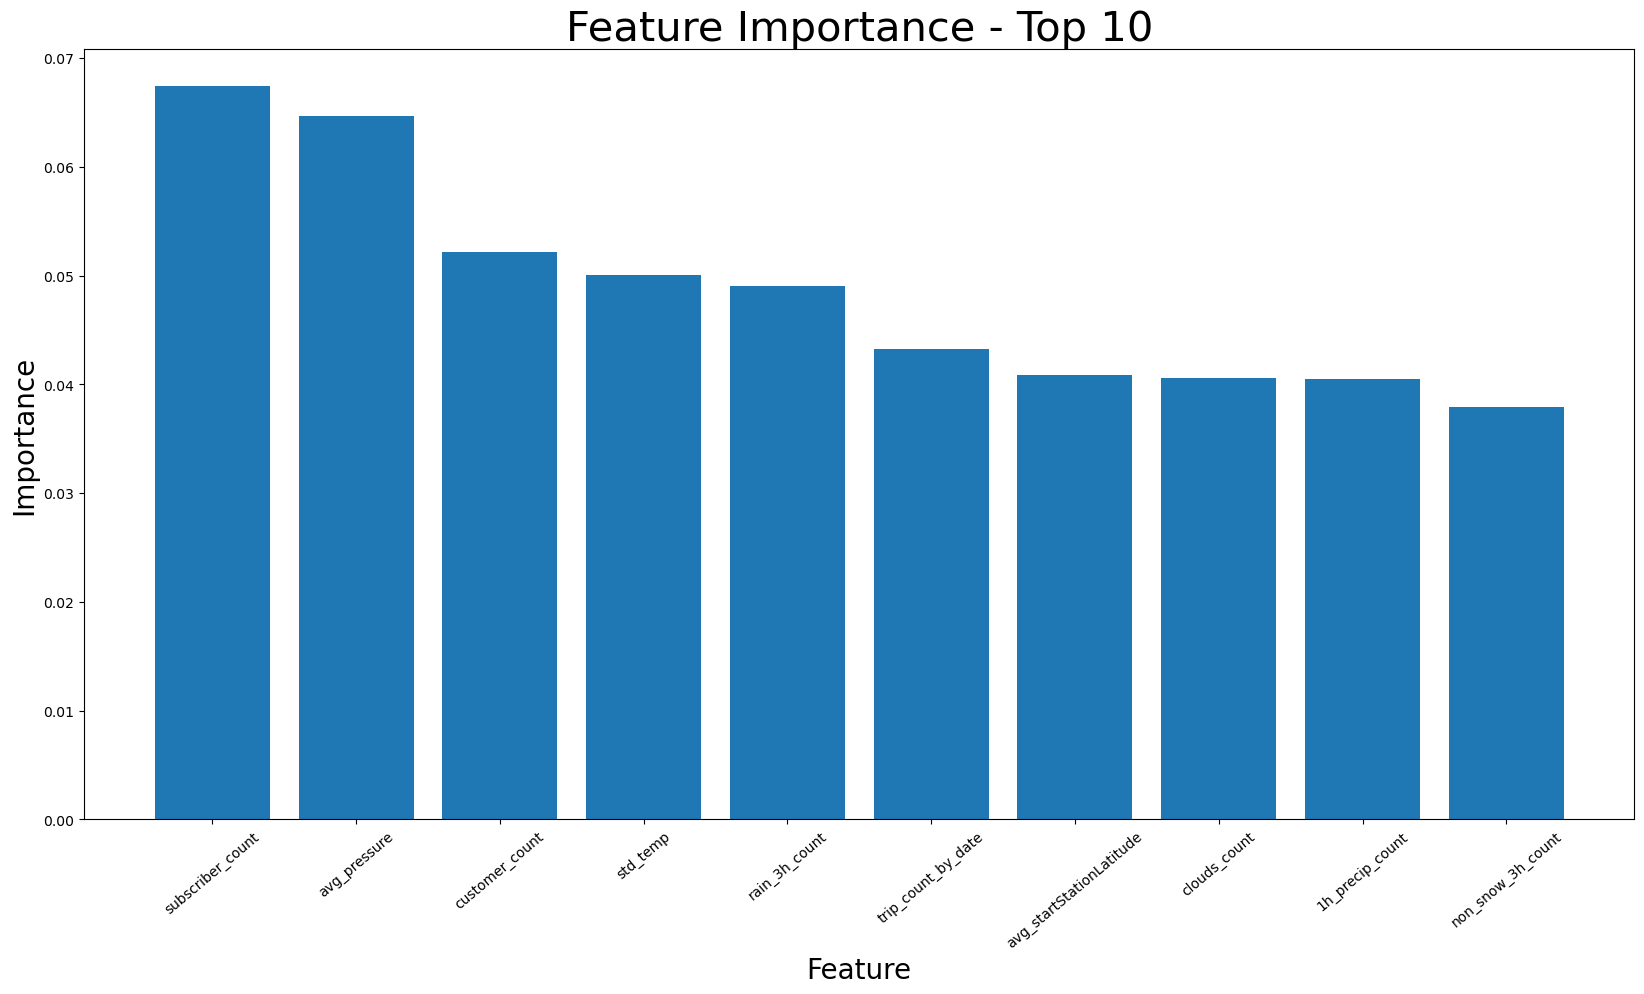

In [56]:
#plot of Feature Importance - need to work on graph look
plt.rcParams["figure.figsize"] = (20, 10)
plt.bar(x_values[0:10], df_ticks["weight"], orientation = 'vertical')
plt.xticks(x_values[0:10], df_ticks["name"], rotation=40)
plt.ylabel('Importance', size=20)
plt.xlabel('Feature', size=20)
plt.title('Feature Importance - Top 10', size=30)
plt.show()